**Instructors**: Prof. Keith Chugg (chugg@usc.edu) & Prof. Antonio Ortega (aortega@usc.edu)

**Teaching Assistant**: Alexios Rustom (arustom@usc.edu)

**Book**: Watt, J., Borhani, R., & Katsaggelos, A. K. (2020). Machine learning refined: Foundations, algorithms, and applications. Cambridge University Press.

**Notebooks**: Written by Alexios Rustom (arustom@usc.edu) and based on the following **Github repository**: [notebooks](https://github.com/jermwatt/machine_learning_refined/tree/gh-pages/presentations/2nd_edition/jupyter%20%2B%20reveal.js%20version)

# Kernel Methods

In [1]:
import numpy as np
import autograd.numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import seaborn as sns
readDataPath = './readData/'
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVC

We have introduced fixed-shape universal approximators as collections of various nonlinear features which have no internal (tunable) parameters. In this Section we pick up that discussion, beginning a deeper dive into the technicalities associated with fixed-shape approximators and challenges we have to address when employing them in practice.

- What generally characterizes fixed-shaped universal approximators are:
    - their lack of internal parameters, and 
    - straightforward organization of units in terms of, e.g., degree 

- These characteristics make fixed-shape approximators, like the polynomials extremely popular in many areas adjacent to machine learning such as applied mathematics, physics, and engineering.

#### <span style="color:#a50e3e;">Example. </span>  Sinusoidal approximators

The collection of sine waves of increasing frequency is a common example of a classic fixed-shape approximator.

\begin{equation}
f_1(x) = \text{sin}(x), \quad f_2(x) = \text{sin}(2x), \quad f_3(x) = \text{sin}(3x), \quad \text{etc.}
\end{equation}

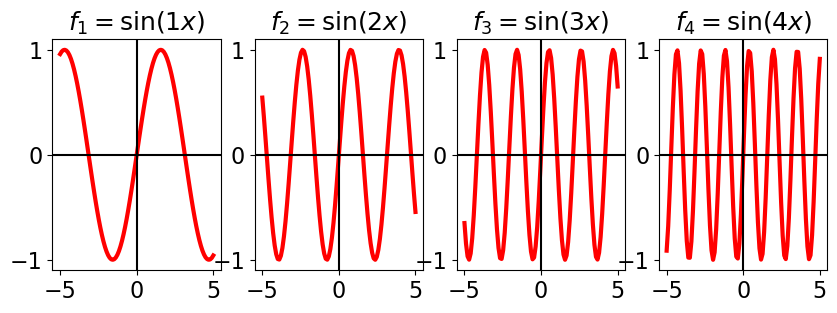

In [2]:
## This code cell will not be shown in the HTML version of this notebook
# build the first 4 non-constant polynomial basis elements
x = np.linspace(-5,5,100)
fig = plt.figure(figsize = (10,3))

for m in range(1,5):
    # make basis element
    fm = np.sin(m*x)
    fm_table = np.stack((x,fm),axis = 1)
    
    # plot the current element
    ax = fig.add_subplot(1,4,m)
    ax.plot(fm_table[:,0],fm_table[:,1],color = 'r',linewidth = 3)
    ax.set_title('$f_'+str(m) + ' = '  + '$sin$ ' +  '(' + str(m) + 'x)$',fontsize = 18)

    # clean up plot
    #ax.grid(True, which='both')
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    
    ax.tick_params(axis="x", labelsize=16)
    ax.tick_params(axis="y", labelsize=16)

    ax.set_xticks([-5,0,5])
    ax.set_yticks([-1,0,1])
    
plt.show()

Akin to the polynomials, we can generalize this catalog of functions to $N$ dimensional input 

\begin{equation}
f_m\left(\mathbf{x}\right) = \text{sin}\left(m_1x_1\right)\text{sin}\left(m_2x_2\right)\cdots \text{sin}\left(m_Nx_N\right)
\end{equation}

Here $m_1,\,m_2,\,...,m_N$ are nonnegative integers. 

#### <span style="color:#a50e3e;">Example. </span>  Fourier approximators

The Fourier approximators or basis consists of the set of paired sine and cosine waves with ever-increasing frequency of the form

\begin{equation}
f_{2m-1}\left(x\right)=\text{sin}\left(2 \pi mx\right) \quad \text{and} \quad f_{2m}\left(x\right)=\text{cos}\left(2 \pi mx\right) \quad  
\end{equation}

It is also common to write the Fourier units using classic complex exponential definitions of both cosine and sine

\begin{equation}
f_{m}\left(x\right)=e^{2\pi imx}
\end{equation}

For a general $N$ dimensional input each multidimensional Fourier unit takes the form 

\begin{equation}
f_{m}\left(\mathbf{x}\right)=e^{2\pi im_{1}x_{1}}e^{2\pi im_{2}x_{2}}\cdots e^{2\pi im_{N}x_{N}}
\end{equation}

Here $m_1,\,m_2,\,...,m_N$ are nonnegative integers.

### Large input dimensions and the scaling challenge

With $N$ dimensional input a polynomial unit takes the form 

\begin{equation}
f_m\left(\mathbf{x}\right) = x_1^{m_1}x_2^{m_2}\cdots x_N^{m_N}
\end{equation}

To construct a polynomial model of degree $D$ we collect all such terms where
$$m_1 + m_2 + \cdots + m_N \leq D$$ 

- It is easy to verify that the precise number $M$ of (non-bias) features/feature weights of a degree $D$ polynomial is $\left(\begin{array}{c}
N+D\\
D
\end{array}\right)-1=\frac{\left(N+D\right)!}{N!D!}-1$.

- Even if the input dimension is of reasonably small size, for instance $N=100$ or $N=500$, then just the associated degree $D=5$ polynomial feature map of these input dimensions has dimension $M= 96,560,645$ and $M=268,318,178,226$ respectively! 

- This serious scaling issue motivates the so-called *kernel trick*. 

## The Kernel Trick

- This crucial issue, of not being able to effectively store and compute with high dimensional fixed-shape feature transformations, motivates notion of *kernelization*. 

- Kernelization not only allows us to avoid this scaling problem, but also provides a way of generating new fixed-shape features defined solely through such a kernelized representation.

###  A useful fact from the fundamental theorem of linear algebra

Before discussing the concept of kernelization, it will be helpful to first recall a useful proposition from the fundamental theorem of linear algebra about decomposition of any vector $\boldsymbol{\omega}$ in $\mathbb{R}^M$ over the columns of a given $M \times P$ matrix $\mathbf{F}$. Denoting the $p^{th}$ column of $\mathbf{F}$ as $\mathbf{f}_p$, when $\boldsymbol{\omega}$ happens to lie *inside* the column space of $\mathbf{F}$ we can express it, via a linear combination of these columns, as 

\begin{equation}
\boldsymbol{\omega} = \sum_{p=1}^{P} \mathbf{f}_p\,z_p
\end{equation}

where $z_p$ is the weight associated with $\mathbf{f}_p$. By stacking these weights into a $P \times 1$  column vector $\mathbf{z}$ we can write this relationship more compactly as

\begin{equation}
\boldsymbol{\omega} = \mathbf{F}\mathbf{z}
\end{equation}

If, on the other hand, $\boldsymbol{\omega}$ happens to lie *outside* the column space of $\mathbf{F}$, as illustrated pictorially in Figure 1, we can decompose it into two pieces: the portion of $\boldsymbol{\omega}$ belonging to the subspace spanned by the columns of $\mathbf{F}$ and an orthogonal component $\mathbf{r}$

\begin{equation}
\boldsymbol{\omega} = \mathbf{F}\mathbf{z}+\mathbf{r}
\end{equation}

Note that $\mathbf{r}$ being orthogonal to the span of columns in $\mathbf{F}$ means, algebraically, that $\mathbf{F}^T\mathbf{r}=\mathbf{0}_{P \times 1}$. Moreover when $\boldsymbol{\omega}$ is in the column space of $\mathbf{F}$, we can still decompose it using the form given in Equation(?) by setting $\mathbf{r}=\mathbf{0}_{M \times 1}$, which clearly satisfies the orthogonality condition $\mathbf{F}^T\mathbf{r}=\mathbf{0}_{P \times 1}$. As we will now see this simple decomposition is the key to representing fixed-shape features more effectively.   

###  Kerenlizing machine learning cost functions

Here we provide several fundamental examples of how to kernelize standard supervised machine learning problems and their cost functions, including Least Squares regression, the Softmax cost for two-class classification.  Virtually all machine learning cost functions can be kernelized following arguments similar to these, including multi-class classification, Principal Component Analysis, and K-means clustering.

#### <span style="color:#a50e3e;">Example.</span> Kernelizing regression via the Least Squares cost

Suppose we want to perform a generic nonlinear regression using $B$ units and the corresponding model evaluated at the $p^{th}$ input $\mathbf{x}_p$ 

\begin{equation}
\text{model}\left(\mathbf{x}_p,\mathbf{w}\right) = w_0 + f_1\left(\mathbf{x}_p\right)w_1 + f_2\left(\mathbf{x}_p\right)w_2 + \cdots + f_B\left(\mathbf{x}_p\right)w_B.
\end{equation}

Using the compact notation

$$
b = w_0 \,\,\,\,\,\,\, \,\,\,\,\,\, \boldsymbol{\omega} = 
\begin{bmatrix}
w_1 \\
w_2 \\ 
\vdots \\
w_N
\end{bmatrix}\,\,\,\,\,\,\, \,\,\,\,\,\, 
\mathbf{f}_{p}=\begin{bmatrix}
f_1\left(\mathbf{x}_p\right)\\
f_2\left(\mathbf{x}_p\right)\\
\vdots\\
f_B\left(\mathbf{x}_p\right)
\end{bmatrix}
$$

we can write our model more compactly - exposing the features apart from our bias - as

\begin{equation}
\text{model}\left(\mathbf{x}_p,b,\boldsymbol{\omega}\right) = b + \mathbf{f}_p^T\boldsymbol{\omega}
\end{equation}

In this notation our Least Squares cost for regression takes the form 

\begin{equation}
g\left(b,\boldsymbol{\omega}\right) = \frac{1}{P}\sum_{p=1}^{P} \left(b+\mathbf{f}_p^T\boldsymbol{\omega}-y_p\right)^2.
\end{equation}

Denote by $\mathbf{F}$ the $B \times P$ matrix $\mathbf{F}$ formed by stacking the vectors $\mathbf{f}_p$ column-wise. Now, employing the fundamental theorem of linear algebra discussed above we may write $\mathbf{w}$ here as

\begin{equation}
\boldsymbol{\omega} = \mathbf{F}\mathbf{z}+\mathbf{r}
\end{equation}

where $\mathbf{r}$ satisfies $\mathbf{F}^T\mathbf{r}=\mathbf{0}_{P \times 1}$.  

Plugging this representation of $\mathbf{w}$ back into the cost function then gives

\begin{equation}
\frac{1}{P}\sum_{p=1}^{P} \left(b+\mathbf{f}_p^T\left(\mathbf{F}\mathbf{z}+\mathbf{r}\right)-y_p\right)^2 = \frac{1}{P}\sum_{p=1}^{P} \left(b+\mathbf{f}_p^T\mathbf{F}\mathbf{z}-y_p\right)^2 
\end{equation}

Finally, denoting the symmetric $P\times P$ *kernel matrix* $\mathbf{H} = \mathbf{F}^T\mathbf{F}$ (and where $\mathbf{h}_p = \mathbf{F}^T\mathbf{f}_p$ is the $p^{th}$ column of this matrix), referred to as a *kernel matrix* or just the *kernel*, our original cost function becomes equivalently

\begin{equation}
g\left(b,\mathbf{z}\right) = \frac{1}{P} \sum_{p=1}^{P} \left(b+\mathbf{h}_p^T\mathbf{z}-y_p\right)^2
\end{equation}

Our corresponding model evaluated at the $p^{th}$ input now takes the form

\begin{equation}
\text{model}\left(\mathbf{x}_p,b,\mathbf{z}\right) = b + \mathbf{h}_p^T\mathbf{z}.
\end{equation}

Note that we have changed the arguments of the cost function from $g\left(b,\mathbf{w}\right)$ to $g\left(b,\mathbf{z}\right)$ due to our substitution of $\boldsymbol{\omega}$. 

#### <span style="color:#a50e3e;">Example 2. </span> Kernelizing two-class classification via the softmax cost

Writing our generic two-class Softmax cost using the same notation as employed in the previous Example we have

\begin{equation}
g\left(b,\boldsymbol{\omega}\right)=\frac{1}{P}\underset{p=1}{\overset{P}{\sum}}\text{log}\left(1+e^{-y_{p}\left(b+\mathbf{f}_{p}^{T}\boldsymbol{\omega}\right)}\right)
\end{equation}

Using the fundamental theorem of linear algebra for any $\boldsymbol{\omega}$
we can then write $\boldsymbol{\omega}=\mathbf{F}\mathbf{z}+\mathbf{r}$ where
$\mathbf{F}^{T}\mathbf{r}=\mathbf{0}_{P\times1}$. Making this substitution
into the above and simplifying gives

\begin{equation}
g\left(b,\mathbf{z}\right)=\begin{aligned}\frac{1}{P}\underset{p=1}{\overset{P}{\sum}}\text{log}\left(1+e^{-y_{p}\left(b+\mathbf{f}_{p}^{T}\mathbf{F}\mathbf{z}\right)}\right)\end{aligned}
\end{equation}

and denoting the $P\times P$ kernel matrix $\mathbf{H}=\mathbf{F}^{T}\mathbf{F}$
(where $\mathbf{h}_{p}=\mathbf{F}^{T}\mathbf{f}_{p}$ is the $p^{th}$
column of $\mathbf{H}$) we can then write the above in kernelized
form as

\begin{equation}
g\left(b,\mathbf{z}\right)=\begin{aligned}\frac{1}{P}\underset{p=1}{\overset{P}{\sum}}\text{log}\left(1+e^{-y_{p}\left(b+\mathbf{h}_{p}^{T}\mathbf{z}\right)}\right)\end{aligned}
\end{equation}

This kernelized form of the Softmax is often referred to as *kernelized logistic regression* or *kernelized support vector machines*.

Using the same sort of argument, we may kernelize many machine learning problems, summarized for convenience in the table below.

## Popular kernels

The real value of kernelizing any machine learning cost is that the kernel matrix $\mathbf{H}=\mathbf{F}^T\mathbf{F}$  may be constructed *without* first building the matrix $\mathbf{F}$, as we will see through the examples below. 

#### <span style="color:#a50e3e;">Example. </span> The polynomial kernel

A polynomial kernel matrix can be defined entry-wise for general degree $D$ and $N$ dimensional input, as

\begin{equation}
\mathbf{H}_{ij}=\left(1+\mathbf{x}_{i}^{T}\mathbf{x}_{j}\right)^{D}-1
\end{equation}

#### <span style="color:#a50e3e;">Example. </span>  The Fourier kernel

A Fourier kernel matrix can be defined entry-wise for general degree $D$ and $N$ dimensional input, as

\begin{equation}
\mathbf{H}_{ij}=\underset{n=1}{\overset{N}{\prod}}\frac{\text{sin}\left(\left(2D+1\right)\pi\left(x_{in}-x_{jn}\right)\right)}{\text{sin}\left(\pi\left(x_{in}-x_{jn}\right)\right)}-1.
\end{equation}

With this formula we may compute the degree $D$ Fourier features
for arbitrary $N$ dimensional input vectors without calculating the
enormous number of
basis features explicitly. 

#### <span style="color:#a50e3e;">Example. </span>  Kernel representation of radial basis function (RBF) features

Another popular choice of kernel is the radial basis function (RBF) kernel which is typically defined explicitly as a kernel matrix over the input data as

\begin{equation}
\mathbf{H}_{ij}=e^{-\beta\left\Vert \mathbf{x}_{i}-\mathbf{x}_{j}\right\Vert _{2}^{2}}
\end{equation} 

- The larger $\beta$ is set the higher the capacity of the RBF kernel becomes. 

- This is illustrated below via three examples: regression, two-class, and multi-class classification. 

- In each case we use using the RBF kernel with three distinct settings of $\beta$ leading to underfitting, reasonable predictive behavior, and overfitting.

##  Making predictions with kernelized models

- Our kernelized form of the general supervised model evaluated at the $p^{th}$ input $\mathbf{x}_p$ took the form $b + \mathbf{h}_p^T\boldsymbol{\omega}$, where $\mathbf{h}_p$ is the $p^{th}$ column of a $P\times P$ kernel $\mathbf{H}$.


- Notice how this involves the evaluation of every point in the training set against the input $\mathbf{x}_p$, e.g., the following form of $\mathbf{h}_p$ for a polynomial kernel

\begin{equation}
\mathbf{h}_p = 
\begin{bmatrix}
\left(1 + \mathbf{x}_1^T\mathbf{x}_p\right)^D + 1 \\
\left(1 + \mathbf{x}_2^T\mathbf{x}_p\right)^D + 1 \\
\vdots \\
\left(1 + \mathbf{x}_P^T\mathbf{x}_p^{\,}\right)^D + 1
\end{bmatrix}.
\end{equation}

- Assuming parameters $b$ and $\boldsymbol{\omega}$ have been fully tuned, the following model can be used for prediction purposes. 

\begin{equation}
\text{model}\left(\mathbf{x},b,\mathbf{z}\right) = b + \mathbf{h}^T\mathbf{z}
\end{equation}

- Here the kernelization $\mathbf{h}$ of the generic input $\mathbf{x}$ involves evaluation against *every point in the training set*. For instance, in the case of polynomials $\mathbf{h}$ is given as 

\begin{equation}
\mathbf{h} = 
\begin{bmatrix}
\left(1 + \mathbf{x}_1^T\mathbf{x}\right)^D + 1 \\
\left(1 + \mathbf{x}_2^T\mathbf{x}\right)^D + 1 \\
\vdots \\
\left(1 + \mathbf{x}_P^T\mathbf{x}^{\,}\right)^D + 1
\end{bmatrix}.
\end{equation}

- This necessity - to employ **every training point in making predictions** - is virtually unique to kernelized learners. 

## Kernels as Similarity Measures

- Studying the RBF kernel $\mathbf{H}_{ij} =e^{-\beta\left\Vert \mathbf{x}_{i}-\mathbf{x}_{j}\right\Vert _{2}^{2}}$ we can interpret it as a *similarity measure* between the two inputs $\mathbf{x}_i$ and $\mathbf{x}_j$.

- The more similar $\mathbf{x}_i$ and $\mathbf{x}_j$ are in the input space the larger $\mathbf{H}_{ij}$ becomes, attaining the value $1$ when $\mathbf{x}_i = \mathbf{x}_j$.

- The further apart the two inputs the smaller $\mathbf{H}_{ij}$ becomes, attaining $0$ when they are infinitely far apart.

The interpretation of kernels as similarity measures also applies to other previously introduced kernels including the polynomial and Fourier kernels, even though these kernels clearly encode similarity in different ways (as shown below).

## Optimization of Kernelized Models

- Because the final kernelized model remains linear in its parameters (the kernels themselves having no internal parameters tuned during optimization), corresponding kernelized cost functions themselves are quite 'nice' in terms of their general shape. 

- For example, any convex cost function for regression and classification *remains convex when kernelized*.

- This allows virtually any optimization method to be used to tune a kernelized supervised learner - from zero to first order and even powerful second order approaches like Newton's method.

- Notice, because kernel matrices $\mathbf{H}$ are sized $P \times P$ - where $P$ is the size of the training set - they inherently scale very poorly in the size of training data.

- For example, with $P=10,000$ the corresponding kernel matrix will be of size $10,000 \times 10,000$, with $10^8$ values to store, far more than a modern computer can store all at once.

- Most standard ways of dealing with this crippling scaling issue revolve around avoiding the creation of the entire kernel matrix $\mathbf{H}$, especially during training.

- For example, one can use first order methods such as stochastic gradient descent to avoid construction of the entire kernel $\mathbf{H}$ during training. 

- Sometimes the explicit structure of certain problems allows can allow for the avoidance of explicit kernel construction as well.

## Cross-Validating Kernelized  Learners

- In general, there is a large difference between the capacity of subsequent degrees $D$ and $D + 1$ in models employing polynomial and Fourier kernels.

- With polynomials for instance, the difference between the number of units encapsulated in a degree-$D$ polynomial kernel and that of a degree-$(D + 1)$ polynomial kernel can be found as $\binom{N+D}{D+1}$.

- When $N = 500$, for example, there are 20,958,500 more polynomial units encapsulated in a degree $D = 3$ kernel matrix than a degree $D = 2$ kernel matrix.

- Because of this enormous combinatorial leap in capacity between subsequent degree kernels, cross-validation via regularization with the $\ell_2$ norm is common practice when employing polynomial and Fourier kernels.

- Since the hyperparameter $\beta$ of the RBF kernel is continuous, models employing an RBF kernel can (in addition to the regularization approach) be cross-validated in principle by comparing various values of $\beta$ directly.

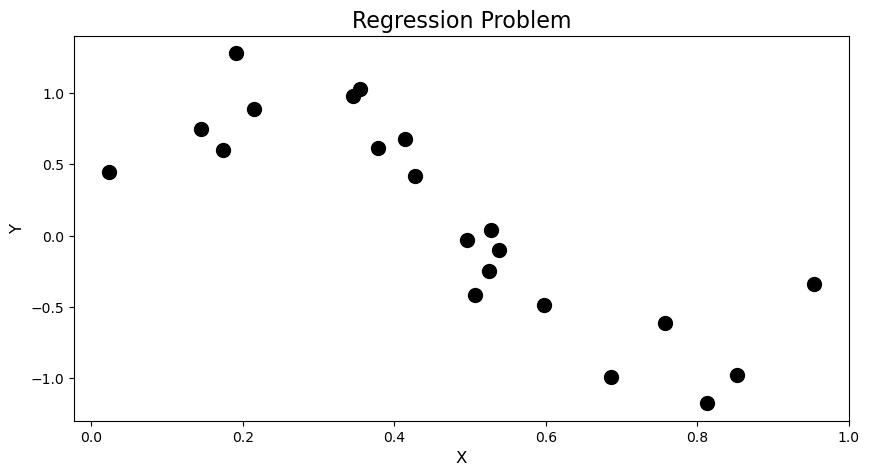

In [3]:
csvname = readDataPath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:].T # up to last row (exclusive) of data & all columns
y = data[-1:,:].T # last row of data & all columns
plt.figure(figsize=(10, 5))
plt.scatter(x,y,s=100,facecolors='k', edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Regression Problem', fontsize=16)
plt.show()

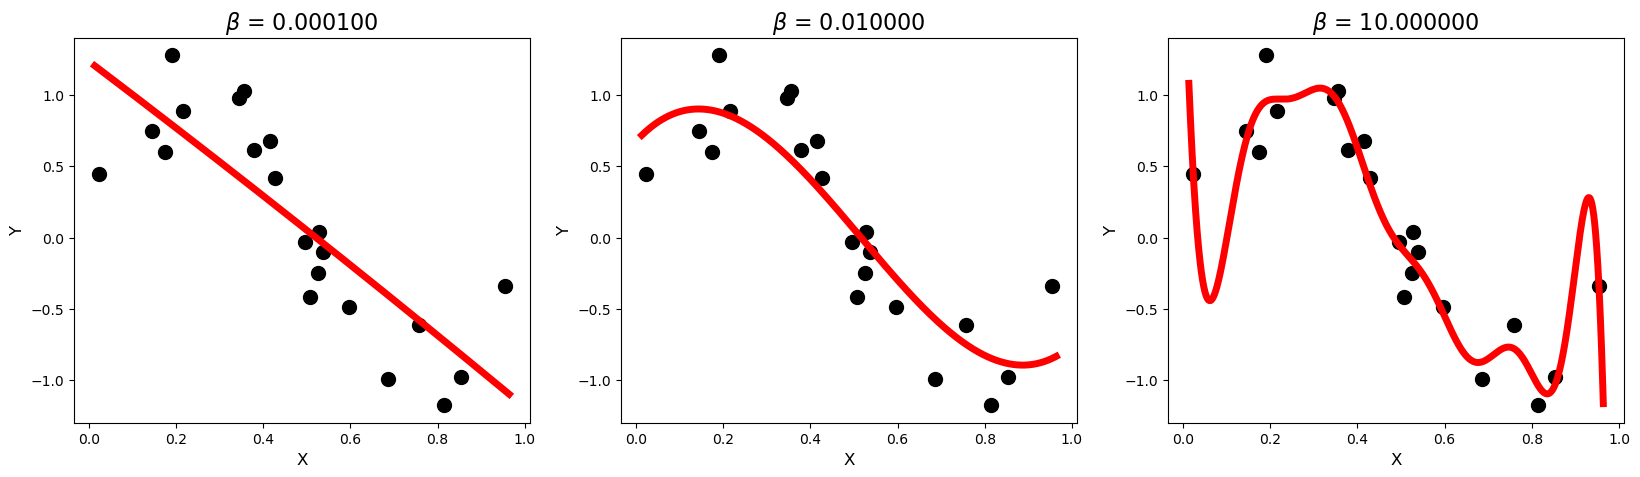

In [4]:
fig, axs = plt.subplots(1,3, figsize = (20,5))
n = 0;
for beta_value in [0.0001, 0.01, 10]:
    krr = KernelRidge(alpha=1e-8, kernel='rbf', gamma=beta_value)
    krr.fit(x, y)
    x_predicted = np.linspace(min(x)-0.01,max(x)+0.01,1000).reshape(-1, 1)
    y_predicted = krr.predict(x_predicted)
    axs[n].scatter(x,y,s=100,facecolors='k', edgecolors='k')
    axs[n].set_xlabel('X', fontsize = 12)
    axs[n].set_ylabel('Y', fontsize = 12)
    axs[n].set_title(r'$\beta$ = %f' %beta_value, fontsize=16)
    axs[n].plot(x_predicted,y_predicted,'r-',linewidth=5)
    n = n+1

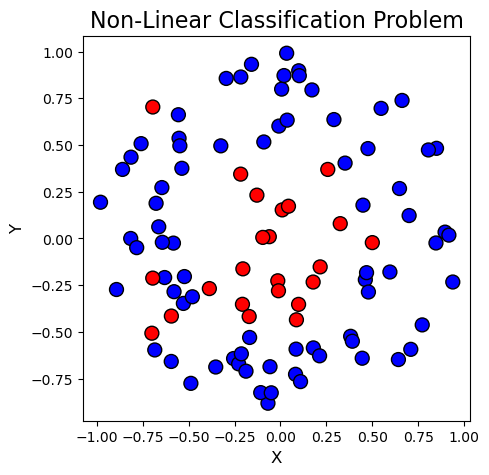

In [5]:
csvFile = readDataPath + 'new_circle_data.csv'
data = np.loadtxt(csvFile,delimiter = ',')
x = data[:-1,:].T
y = data[-1,:]
y.shape = (1,len(y))
data = pd.DataFrame(data)
data = data.T
data.columns=["X", "Y", "Label"]
plt.figure(figsize=(5, 5))
col = np.where(data["Label"]==1,'r','b')
plt.scatter(data["X"],data["Y"],s=100,c=col, edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Non-Linear Classification Problem', fontsize=16)
plt.show()

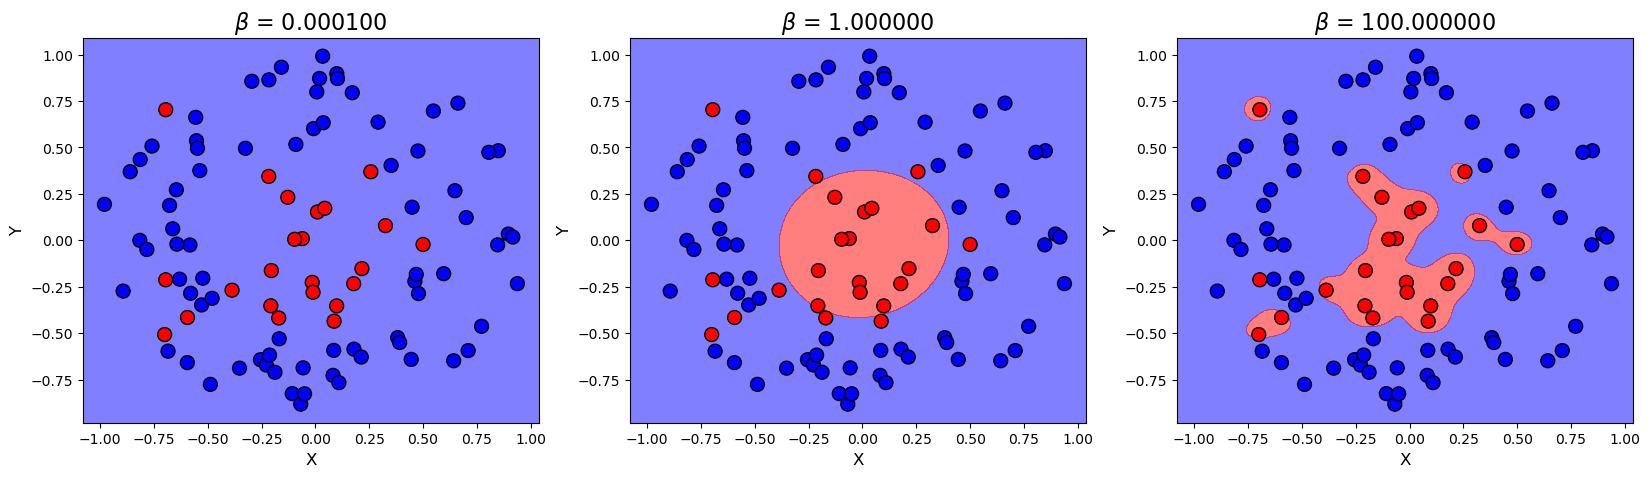

In [6]:
fig, axs = plt.subplots(1,3, figsize = (20,5))
h = 0.001
x_min, x_max = x[:,0].min() - 0.1, x[:,0].max() + 0.1
y_min, y_max = x[:,1].min() - 0.1, x[:,1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
n = 0;
for beta_value in [0.0001, 1, 100]:
    svclassifier = SVC(kernel='rbf', gamma= beta_value)
    svclassifier.fit(x, np.squeeze(y))
    Z = svclassifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axs[n].contourf(xx, yy, Z+1, levels = range(0,3+1), alpha=0.5, colors = ['blue', 'red'])
    axs[n].set_xlabel('X', fontsize = 12)
    axs[n].set_ylabel('Y', fontsize = 12)
    axs[n].set_title(r'$\beta$ = %f' %beta_value, fontsize=16)
    axs[n].scatter(data["X"],data["Y"],s=100,c=col, edgecolors='k')
    n = n+1

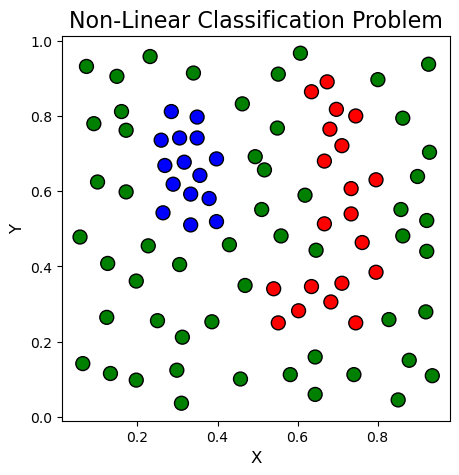

In [7]:
csvname = readDataPath + '2eggs_multiclass.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:].T
y = data[-1,:]
y.shape = (1,len(y))
data = pd.DataFrame(data)
data = data.T
data.columns=["X", "Y", "Label"]
plt.figure(figsize=(5, 5))
col_3C = np.where(data['Label']==0,'b',np.where(data['Label']==1,'r',np.where(data['Label']==2,'g', 'k')))
plt.scatter(data["X"],data["Y"],s=100,c=col_3C, edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Non-Linear Classification Problem', fontsize=16)
plt.show()

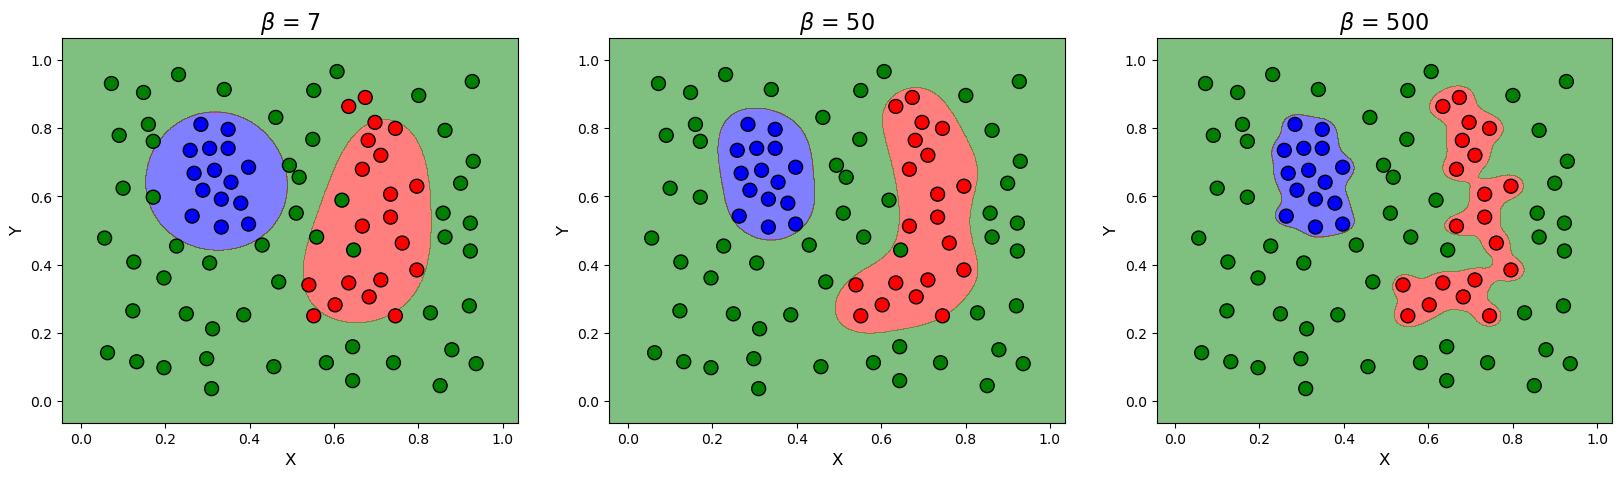

In [8]:
fig, axs = plt.subplots(1,3, figsize = (20,5))
h = 0.001
x_min, x_max = x[:,0].min() - 0.1, x[:,0].max() + 0.1
y_min, y_max = x[:,1].min() - 0.1, x[:,1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
n = 0;
for beta_value in [7, 50, 500]:
    svclassifier = SVC(kernel='rbf', gamma= beta_value)
    svclassifier.fit(x, np.squeeze(y))
    Z = svclassifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axs[n].contourf(xx, yy, Z+1, levels = range(0,3+1), alpha=0.5, colors = ['blue', 'red', 'green'])
    axs[n].set_xlabel('X', fontsize = 12)
    axs[n].set_ylabel('Y', fontsize = 12)
    axs[n].set_title(r'$\beta$ = %d' %beta_value, fontsize=16)
    axs[n].scatter(data["X"],data["Y"],s=100,c=col_3C, edgecolors='k')
    n = n+1